# TensorFlow2 DenseNet-BiLSTM-CRF

## 1.导入数据
使用BROOK数据集 

In [79]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
import matplotlib.colors as colors
import tensorflow_addons as tfa
import os.path 
from tensorflow_addons.layers import CRF

In [80]:
txt_file = 'person/person4_train.txt'
# txt_file = 'dataset/speedtxt/train.txt'
f = open(txt_file)
imgspaths = []
speeds = []
for line in f.readlines():
    filename = line.split(',')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspaths.append(filename)
        speeds.append(int(speed))
    
y_train = np.array(speeds)



In [81]:
max_unit = np.max(y_train)

In [82]:
txt_file = 'person/person4_test.txt'
# txt_file = 'dataset/speedtxt/test.txt'
f = open(txt_file)
imgspath2 = []
speeds = []
for line in f.readlines():
    filename = line.split(',')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspath2.append(filename)
        speeds.append(int(speed))
y_test = np.array(speeds)
        

In [83]:
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg']
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751562024.jpg']
# y_train = [[53],[54],[55]]
x_train = []
for imgspath in imgspaths:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
    img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_train.append(img)
x_train = np.array(x_train)

In [84]:
# imgspath2 = ['1565752827880.jpg']
# y_test = [[55]]
x_test = []
for imgspath in imgspath2:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
    img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_test.append(img)
x_test = np.array(x_test)

In [85]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [86]:
validation_set = (x_test, y_test)

## CNN和LSTM结果合并

In [87]:
from tensorflow.keras import layers
model = keras.Sequential()

In [88]:
x_shape = x_train.shape
cnet2 = DenseNet201(
    input_shape=(x_shape[1], x_shape[2], x_shape[3]),
    weights='imagenet',
    include_top=False
)
cnet2.trainable = True
img_input = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
base_model = cnet2(img_input)

# pool = layers.GlobalAveragePooling2D()(final_layer)
flat = layers.Flatten()(base_model)
dense1 = layers.Dense(64)(flat)

In [89]:
# merged_layer = layers.concatenate([dense1, dense2])
merged_layer = dense1
outt = layers.Dense(max_unit+1,activation='softmax')(merged_layer)
model = keras.Model(inputs=img_input, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
flatten_5 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                122944    
_________________________________________________________________
dense_11 (Dense)             (None, 101)               6565      
Total params: 18,451,493
Trainable params: 18,222,437
Non-trainable params: 229,056
_________________________________________________________________


In [90]:
# time
history2 = model.fit(x_train, y_train, batch_size=64,epochs=200, validation_data = validation_set)

Epoch 1/200
173/173 [==============================] - 71s 408ms/step - loss: 2.4473 - accuracy: 0.4439 - val_loss: 6.9691 - val_accuracy: 0.0573
Epoch 2/200
173/173 [==============================] - 69s 397ms/step - loss: 2.0571 - accuracy: 0.4793 - val_loss: 3.4711 - val_accuracy: 0.4585
Epoch 3/200
173/173 [==============================] - 69s 397ms/step - loss: 1.8138 - accuracy: 0.5110 - val_loss: 2.8271 - val_accuracy: 0.4908
Epoch 4/200
173/173 [==============================] - 69s 396ms/step - loss: 1.6417 - accuracy: 0.5373 - val_loss: 2.4321 - val_accuracy: 0.4773
Epoch 5/200
173/173 [==============================] - 69s 400ms/step - loss: 1.5201 - accuracy: 0.5540 - val_loss: 2.2646 - val_accuracy: 0.4897
Epoch 6/200
173/173 [==============================] - 69s 399ms/step - loss: 1.3998 - accuracy: 0.5794 - val_loss: 3.1952 - val_accuracy: 0.4276
Epoch 7/200
173/173 [==============================] - 69s 400ms/step - loss: 1.2825 - accuracy: 0.6036 - val_loss: 2.7450 -

Epoch 57/200
173/173 [==============================] - 69s 401ms/step - loss: 0.1361 - accuracy: 0.9546 - val_loss: 3.0753 - val_accuracy: 0.5727
Epoch 58/200
173/173 [==============================] - 69s 401ms/step - loss: 0.1459 - accuracy: 0.9532 - val_loss: 4.4298 - val_accuracy: 0.4606
Epoch 59/200
173/173 [==============================] - 69s 399ms/step - loss: 0.1539 - accuracy: 0.9522 - val_loss: 1.9526 - val_accuracy: 0.6485
Epoch 60/200
173/173 [==============================] - 69s 402ms/step - loss: 0.1126 - accuracy: 0.9633 - val_loss: 2.5505 - val_accuracy: 0.5952
Epoch 61/200
173/173 [==============================] - 69s 400ms/step - loss: 0.1352 - accuracy: 0.9563 - val_loss: 4.5356 - val_accuracy: 0.5042
Epoch 62/200
173/173 [==============================] - 69s 401ms/step - loss: 0.0987 - accuracy: 0.9688 - val_loss: 3.3375 - val_accuracy: 0.5394
Epoch 63/200
173/173 [==============================] - 70s 404ms/step - loss: 0.1152 - accuracy: 0.9641 - val_loss: 2

173/173 [==============================] - 69s 399ms/step - loss: 0.0662 - accuracy: 0.9802 - val_loss: 5.1119 - val_accuracy: 0.4878
Epoch 113/200
173/173 [==============================] - 69s 398ms/step - loss: 0.0461 - accuracy: 0.9869 - val_loss: 2.5186 - val_accuracy: 0.6503
Epoch 114/200
173/173 [==============================] - 69s 398ms/step - loss: 0.0601 - accuracy: 0.9824 - val_loss: 3.1175 - val_accuracy: 0.6097
Epoch 115/200
173/173 [==============================] - 69s 400ms/step - loss: 0.0492 - accuracy: 0.9868 - val_loss: 2.4998 - val_accuracy: 0.6670
Epoch 116/200
173/173 [==============================] - 69s 400ms/step - loss: 0.0456 - accuracy: 0.9878 - val_loss: 2.3917 - val_accuracy: 0.6696
Epoch 117/200
173/173 [==============================] - 70s 402ms/step - loss: 0.0468 - accuracy: 0.9879 - val_loss: 2.8485 - val_accuracy: 0.6253
Epoch 118/200
173/173 [==============================] - 69s 397ms/step - loss: 0.0468 - accuracy: 0.9874 - val_loss: 2.8354 -

173/173 [==============================] - 69s 398ms/step - loss: 0.0705 - accuracy: 0.9807 - val_loss: 3.9170 - val_accuracy: 0.5201
Epoch 168/200
173/173 [==============================] - 69s 399ms/step - loss: 0.0463 - accuracy: 0.9862 - val_loss: 2.8879 - val_accuracy: 0.6391
Epoch 169/200
173/173 [==============================] - 69s 400ms/step - loss: 0.0301 - accuracy: 0.9921 - val_loss: 3.4235 - val_accuracy: 0.5948
Epoch 170/200
173/173 [==============================] - 69s 400ms/step - loss: 0.0206 - accuracy: 0.9948 - val_loss: 2.8120 - val_accuracy: 0.6420
Epoch 171/200
173/173 [==============================] - 70s 403ms/step - loss: 0.0408 - accuracy: 0.9902 - val_loss: 3.0424 - val_accuracy: 0.6210
Epoch 172/200
173/173 [==============================] - 69s 398ms/step - loss: 0.0488 - accuracy: 0.9866 - val_loss: 3.0859 - val_accuracy: 0.6108
Epoch 173/200
173/173 [==============================] - 69s 400ms/step - loss: 0.0545 - accuracy: 0.9870 - val_loss: 38.4893 

In [91]:
model.evaluate(x=x_test, y=y_test,verbose=1)

87/87 [==============================] - 4s 40ms/step - loss: 19.5931 - accuracy: 0.3990


[19.593080520629883, 0.3989844024181366]

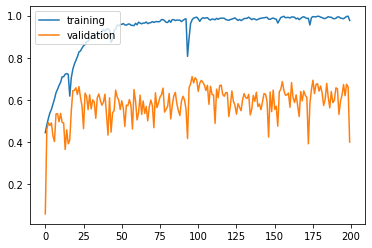

In [92]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [93]:
np.max(history2.history['accuracy'])

0.9969186186790466

In [94]:
np.max(history2.history['val_accuracy'])

0.7101922631263733